In [3]:
import os
from os.path import join as oj
import sys, time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data_pecarn
import data_psrc
import data
import train
import matplotlib.gridspec as grd
from data import feats_numerical, feats_categorical, meta
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imodels import RuleListClassifier, RuleFit, SLIM, GreedyRuleList
from sklearn.linear_model import LinearRegression
import cvxpy as cp

from skrules import SkopeRules
import sklearn.metrics
import validate
# sns.set(style="black")
# plt.style.use('dark_background')
outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

train_idxs = data.pecarn_train_idxs
test_idxs1 = data.pecarn_test_idxs
test_idxs2 = data.psrc_train_idxs + data.psrc_test_idxs
df = df[df.cv_fold.isin(train_idxs)]
print(len(processed_feats), processed_feats)
X, y = df[processed_feats], df[outcome_def]
X_train, y_train = X[:len(y)//2], y[:len(y)//2]
X_test, y_test = X[len(y)//2:], y[len(y)//2:]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


22 ['AbdDistention_yes', 'AbdTenderDegree_Mild', 'AbdTenderDegree_Moderate', 'AbdTenderDegree_None', 'AbdTenderDegree_Severe', 'AbdTrauma_or_SeatBeltSign_yes', 'AbdomenPain_yes', 'Age', 'CostalTender_yes', 'DecrBreathSound_yes', 'GCSScore_Full_yes', 'Hypotension_yes', 'InitHeartRate', 'InitSysBPRange', 'MOI_Bike collision/fall', 'MOI_Fall from an elevation', 'MOI_Motor vehicle collision', 'MOI_Motorcycle/ATV/Scooter collision', 'MOI_Object struck abdomen', 'MOI_Pedestrian/bicyclist struck by moving vehicle', 'ThoracicTrauma_yes', 'VomitWretch_yes']


# fit simple models

**decision tree**

  0%|          | 0/7 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 7/7 [00:00<00:00, 137.80it/s]


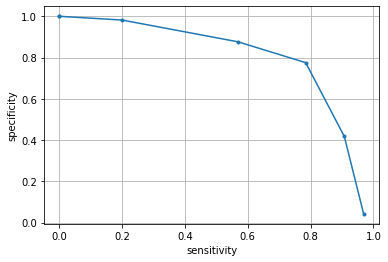

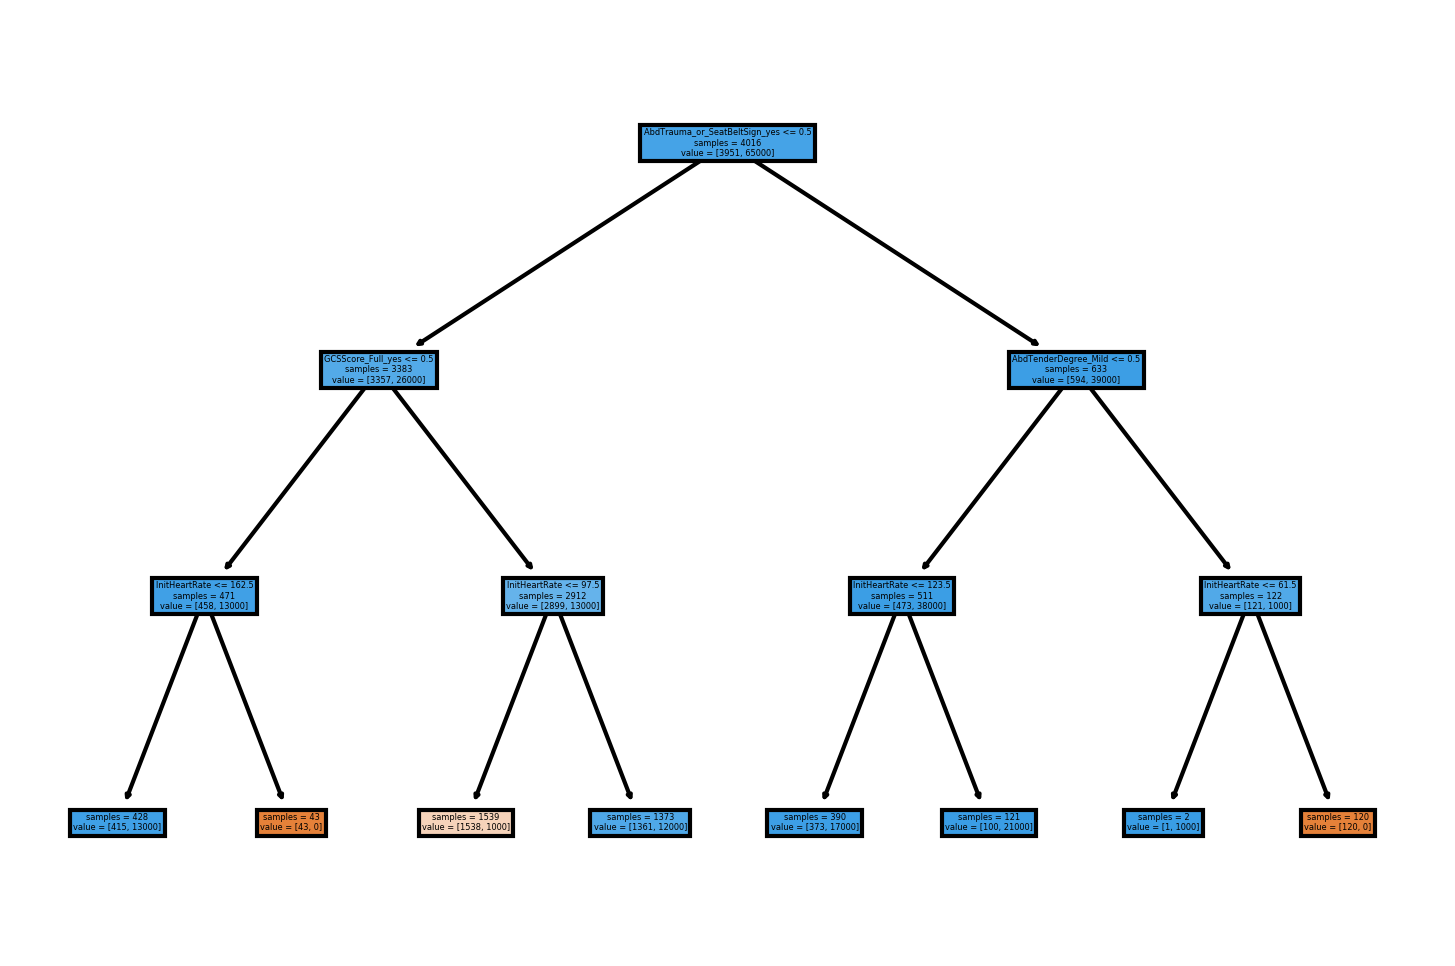

In [5]:
# specify a decision tree with a maximum depth
dt = DecisionTreeClassifier(max_depth=3, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)

# calculat mse on the training data
preds = dt.predict(X_test)
preds_proba = dt.predict_proba(X_test)
# print(preds)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])

# print(f'test: {np.mean(np.square(preds-y_test)):0.2f}')
# print(sklearn.metrics.classification_report(y_test, preds))
plt.figure(dpi=300)
plot_tree(dt, feature_names=processed_feats, impurity=False, filled=True)
# plt.savefig('tree.pdf')
plt.show()

**bayesian rule lists**

training...


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RuleListClassifier Accuracy: 0.9838187702265372 Learned interpretable model:
 Trained RuleListClassifier for detecting IwI
IF DecrBreathSound_yes : 0.5_to_inf THEN probability of IwI: 14.9% (8.3%-23.1%)
ELSE IF AbdTrauma_or_SeatBeltSign_yes : -inf_to_0.5 AND InitSysBPRange : 85.5_to_inf THEN probability of IwI: 0.4% (0.2%-0.7%)
ELSE IF AbdDistention_yes : 0.5_to_inf THEN probability of IwI: 40.5% (25.5%-56.5%)
ELSE IF AbdTenderDegree_Severe : 0.5_to_inf THEN probability of IwI: 25.0% (13.9%-38.0%)
ELSE IF GCSScore_Full_yes : -inf_to_0.5 THEN probability of IwI: 11.5% (5.9%-18.5%)
ELSE probability of IwI: 1.2% (0.4%-2.3%)



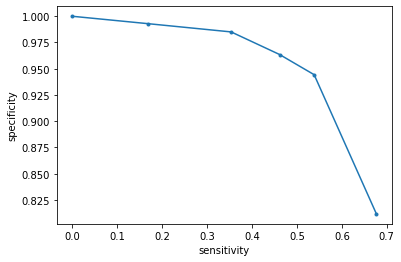

In [4]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training...')
model = RuleListClassifier(max_iter=10000, class1label="IwI", verbose=False)
model.fit(X_train, y_train, feature_labels=processed_feats)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, model.predict_proba(X_test)[:, 1])
print("RuleListClassifier Accuracy:", model.score(X_test, y_test), "Learned interpretable model:\n", model)

**rulefit**

In [ ]:
# fit a rulefit model
rf = RuleFit()
rf.fit(X_train, y_train, feature_names=processed_feats)

100%|█████████▉| 1780/1784 [00:12<00:00, 154.50it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 1784/1784 [00:12<00:00, 142.04it/s]


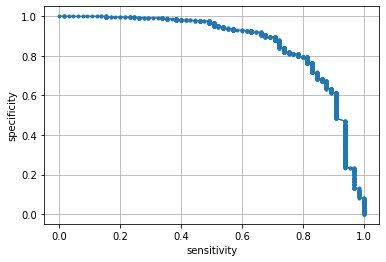

In [4]:
preds = rf.predict(X_test)
# preds_proba = rf.predict_proba(X_test)
# print(preds)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds)
# print(sklearn.metrics.classification_report(y_test, preds))

In [ ]:
rules = rf.get_rules()

rules = rules[rules.coef != 0].sort_values("support", ascending=False)

print(rules)

**slim**

In [17]:
# specify a decision tree with a maximum depth
fewest_feats = data.fewest_feats
X_train_small = X_train[fewest_feats]
m = SLIM()
n = 100


# optionally upweight positive samples
CLASS_WEIGHT = 100
sample_weight = np.ones((n))
sample_weight[y_train[:n] == 1] *= CLASS_WEIGHT
sample_weight /= sample_weight.max()

# fit
m.fit(X_train_small[:n], y_train[:n] * 100, lambda_reg=10,
      sample_weight=sample_weight)

# calculate mse on the training data
X_test_small = X_test[fewest_feats]
preds = m.predict(X_test_small)
preds_proba = [1 / (1 + np.exp(-y)) for y in preds]
# preds_proba = m.predict_proba(X_test)
print(m.model.coef_.astype(int), m.model.intercept_)

shapes (100,) (100,)
[-55  -3   0  14  -4   0 -81 -15   0   0  -5   0] 0


 94%|█████████▍| 140/149 [00:01<00:00, 133.01it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 149/149 [00:01<00:00, 134.66it/s]


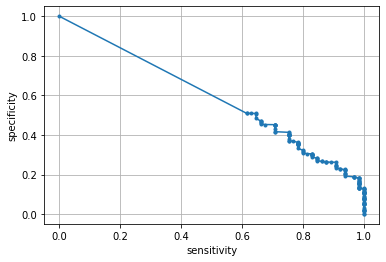

In [18]:
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba)

**skope rules**

Rules for iai
('InitHeartRate > 108.0 and VomitWretch_yes > 0.5 and AbdTenderDegree_Severe > 0.5', (0.788888888888889, 0.15026010404161666, 2))
('AbdDistention_yes > 0.5 and InitSysBPRange > 70.5 and ThoracicTrauma_yes > 0.5', (0.4177462651727357, 0.15884662956091528, 4))
('AbdDistention_yes > 0.5 and InitSysBPRange <= 107.5 and AbdTenderDegree_Severe > 0.5', (1.0, 0.125, 1))
('AbdDistention_yes > 0.5 and InitHeartRate > 112.5 and AbdTenderDegree_Severe > 0.5', (0.75, 0.125, 1))
('AbdDistention_yes > 0.5 and Hypotension_yes <= 0.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5', (0.3455674760022586, 0.15029352778847388, 4))
('AbdDistention_yes > 0.5 and InitSysBPRange > 65.5 and AbdTrauma_or_SeatBeltSign_yes > 0.5', (0.3138461538461539, 0.15384615384615385, 2))
('AbdDistention_yes > 0.5 and Hypotension_yes > 0.5 and DecrBreathSound_yes <= 0.5', (1.0, 0.11363636363636363, 1))
('InitHeartRate <= 150.5 and InitHeartRate > 137.5 and AbdTenderDegree_Severe > 0.5', (1.0, 0.10638297872340426, 1))
('

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


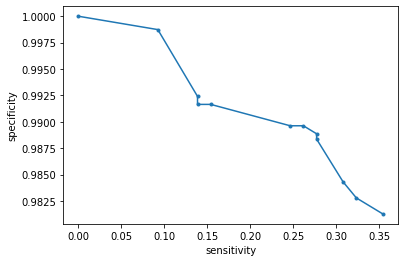

In [2]:
# feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
clf = SkopeRules(max_depth_duplication=3,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=processed_feats)
clf.fit(X_train, y_train)
# print the rules
rules = clf.rules_
print("Rules for iai")
for rule in rules:
    print(rule)

# evaluate
y_score = clf.score_top_rules(X_test) # Get a risk score for each test example

sens, spec = util.sensitivity_specificity_curve(y_test, y_score)
plt.show()

**greedy rule list**

In [20]:
d = GreedyRuleList(max_depth=7)
d.fit(X_train, y_train)

mean 0.016185258964143426
mean 0.011116856256463288
mean 0.008198889182755884
mean 0.0061944519256665765
mean 0.003151591553734636
mean 0.02702702702702703
mean 0.07692307692307693


[{'col': 'AbdTenderDegree_Severe',
  'index_col': 4,
  'cutoff': 1.0,
  'val': 0.016185258964143426,
  'val_right': 0.14864864864864866,
  'num_pts': 4016,
  'num_pts_right': 148},
 {'col': 'AbdDistention_yes',
  'index_col': 0,
  'cutoff': 1.0,
  'val': 0.011116856256463288,
  'val_right': 0.13793103448275862,
  'num_pts': 3868,
  'num_pts_right': 87},
 {'col': 'DecrBreathSound_yes',
  'index_col': 9,
  'cutoff': 1.0,
  'val': 0.008198889182755884,
  'val_right': 0.11764705882352941,
  'num_pts': 3781,
  'num_pts_right': 68},
 {'col': 'AbdTrauma_or_SeatBeltSign_yes',
  'index_col': 5,
  'cutoff': 1.0,
  'val': 0.0061944519256665765,
  'val_right': 0.024074074074074074,
  'num_pts': 3713,
  'num_pts_right': 540},
 {'col': 'InitSysBPRange',
  'index_col': 13,
  'cutoff': 93.0,
  'val': 0.003151591553734636,
  'val_right': 0.0019834710743801653,
  'num_pts': 3173,
  'num_pts_right': 3025},
 {'col': 'GCSScore_Full_yes',
  'index_col': 10,
  'cutoff': 1.0,
  'val': 0.02702702702702703,
  '

In [21]:
def print_list(rules):
    s = ''
    for rule in rules:
        s += f"{(100 * rule['val']).round(3)}% IwI ({rule['num_pts']} pts)\n"
        if 'col' in rule:
            s += f"if {rule['col']} >= {rule['cutoff']} then {(100 * rule['val_right']).round(3)}% IWI ({rule['num_pts_right']} pts)\n"
    print(s)
            
print_list(d.rules_)

1.619% IwI (4016 pts)
if AbdTenderDegree_Severe >= 1.0 then 14.865% IWI (148 pts)
1.112% IwI (3868 pts)
if AbdDistention_yes >= 1.0 then 13.793% IWI (87 pts)
0.82% IwI (3781 pts)
if DecrBreathSound_yes >= 1.0 then 11.765% IWI (68 pts)
0.619% IwI (3713 pts)
if AbdTrauma_or_SeatBeltSign_yes >= 1.0 then 2.407% IWI (540 pts)
0.315% IwI (3173 pts)
if InitSysBPRange >= 93.0 then 0.198% IWI (3025 pts)
2.703% IwI (148 pts)
if GCSScore_Full_yes >= 1.0 then 0.917% IWI (109 pts)
7.692% IwI (39 pts)
if InitHeartRate >= 127.0 then 0.0% IWI (22 pts)

